In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML Training libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier

# RDKit for chemical informatics
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem


In [2]:
# load the dataset
ki_data = pd.read_csv('data/Ki_bind.tsv', sep='\t')

ki_data.head()

,drug_id,target_id,smiles,target_seq,origin_affinity,affinity
0,1,P04183,Cc1cn([C@H]2C[C@H](O)[C@@H](CO)O2)c(=O)[nH]c1=O,MSCINLPTVLPGSPSKTRGQIQVILGPMFSGKSTELMRRVRRFQIA...,200,6.698970
1,1,P11413,Cc1cn([C@H]2C[C@H](O)[C@@H](CO)O2)c(=O)[nH]c1=O,MAEQVALSRTQVCGILREELFQGDAFHQSDTHIFIIMGASGDLAKK...,1.54e+4,4.812479
2,1,P23919,Cc1cn([C@H]2C[C@H](O)[C@@H](CO)O2)c(=O)[nH]c1=O,MAARRGALIVLEGVDRAGKSTQSRKLVEALCAAGHRAELLRFPERS...,180000,3.744727
3,1,P25099,Cc1cn([C@H]2C[C@H](O)[C@@H](CO)O2)c(=O)[nH]c1=O,MPPYISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFC...,>10000,4.999957
4,1,P30543,Cc1cn([C@H]2C[C@H](O)[C@@H](CO)O2)c(=O)[nH]c1=O,MGSSVYITVELAIAVLAILGNVLVCWAVWINSNLQNVTNFFVVSLA...,>10000,4.999957


In [3]:
# inspect columns
ki_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380365 entries, 0 to 380364
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   drug_id          380365 non-null  int64  
 1   target_id        380365 non-null  object 
 2   smiles           380365 non-null  object 
 3   target_seq       380365 non-null  object 
 4   origin_affinity  380365 non-null  object 
 5   affinity         380365 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 17.4+ MB


In [4]:
len(ki_data)

380365

In [5]:
ki_data.describe()

,drug_id,affinity
count,3.803650e+05,380365.000000
mean,3.601509e+07,6.822692
std,2.257446e+07,1.626958
min,1.000000e+00,-5.000000
25%,4.322240e+05,5.700275
50%,5.013560e+07,6.892790
75%,5.031928e+07,8.000000
max,5.054575e+07,14.522879


In [6]:
# check for any null/missing values
ki_data.isnull().sum()

drug_id            0
target_id          0
smiles             0
target_seq         0
origin_affinity    0
affinity           0
dtype: int64

In [7]:
## Exploratory Data Analysis (EDA)
# check for unique smile and protein_target

uniq_smiles = ki_data.smiles.unique()
uniq_targets = ki_data.target_seq.unique()

print(f"Unique SMILES: {len(uniq_smiles)}")
print(f"Unique Protein Targets: {len(uniq_targets)}")

Unique SMILES: 199949
Unique Protein Targets: 2716


In [8]:
# check for unique smile-target pairs
ki_copy = ki_data.copy()
unique_pairs = ki_copy[['smiles', 'target_seq']].drop_duplicates().shape[0]
print(f"Unique SMILES-Target pairs: {unique_pairs}")

Unique SMILES-Target pairs: 379743


In [16]:
ki_clean = ki_copy.drop_duplicates(subset=['smiles', 'target_seq'])
len(ki_clean)

379743

In [12]:
ki_copy['origin_affinity'].value_counts()

origin_affinity
>10000       16316
>1000         5571
>100000       3258
 1000         1900
>5000         1872
             ...  
 177.2           1
 555.1           1
 0.0004          1
 0.000350        1
 144544          1
Name: count, Length: 22006, dtype: int64

In [30]:
ki_copy['affinity'].describe()

count    380365.000000
mean          6.822692
std           1.626958
min          -5.000000
25%           5.700275
50%           6.892790
75%           8.000000
max          14.522879
Name: affinity, dtype: float64

In [31]:
ki_copy['origin_affinity'].describe()

count     380365
unique     22006
top       >10000
freq       16316
Name: origin_affinity, dtype: object

In [14]:
# Aggregate by counts to check if duplicates were true replicates
pair_counts = (ki_data.groupby(['smiles', 'target_seq']).size().reset_index(name='counts'))
pair_counts['counts']

### Getting values of 1 shows that most duplicates were indeed true replicates. hence data cleaning is on the right track

0         1
1         1
2         1
3         1
4         1
         ..
379738    1
379739    1
379740    1
379741    1
379742    1
Name: counts, Length: 379743, dtype: int64

In [32]:
ki_clean['affinity'].value_counts()

affinity
4.999957    16344
5.999566     5582
3.999996     3309
9.000000     2746
8.698970     2392
            ...  
4.748362        1
5.302509        1
4.609772        1
5.279510        1
4.215754        1
Name: count, Length: 19058, dtype: int64

In [34]:
# set biologically relevant affinity threshold
ki_clean = ki_clean[(ki_clean['affinity'] >= 3) & (ki_clean['affinity'] <= 12)] # keeps it in millimolar to picomolar range
ki_clean.reset_index(drop=True, inplace=True)
ki_clean['affinity'].describe()

count    375448.000000
mean          6.883230
std           1.501218
min           3.000000
25%           5.764472
50%           6.920819
75%           8.000000
max          12.000000
Name: affinity, dtype: float64

In [35]:
ki_clean.shape

(375448, 7)

In [42]:
# aggregate by unique smile-target pairs after cleaning
ki_clean = (ki_clean.groupby(['smiles', 'target_seq'], as_index=False).
            agg({'affinity': 'mean'})
            )

ki_clean.shape

(375448, 3)

In [43]:
ki_clean.head()

,smiles,target_seq,affinity
0,B[P@@](=O)(OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1c...,MERDGCAGGGSRGGEGGRAPREGPAGNGRDRGRSHAAEAPGDPQAA...,4.744727
1,B[P@@](=O)(OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1c...,MERDGCAGGGSRGGEGGRAPREGPAGNGRDRGRSHAAEAPGDPQAA...,6.301030
2,B[P@](=O)(OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1cn...,MERDGCAGGGSRGGEGGRAPREGPAGNGRDRGRSHAAEAPGDPQAA...,4.251812
3,B[P@](=O)(OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1cn...,MERDGCAGGGSRGGEGGRAPREGPAGNGRDRGRSHAAEAPGDPQAA...,4.552842
4,B[P@](=O)(OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1cn...,MERDGCAGGGSRGGEGGRAPREGPAGNGRDRGRSHAAEAPGDPQAA...,5.154902


Text(0.5, 1.0, 'Distribution of SMILES Lengths')

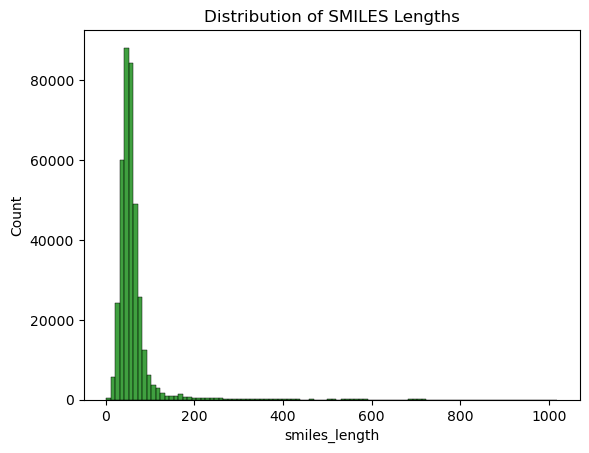

In [44]:
# plot smile length distribution
ki_clean['smiles_length'] = ki_clean['smiles'].apply(len)
sns.histplot(ki_clean['smiles_length'], bins=100, color='green')
plt.title('Distribution of SMILES Lengths')


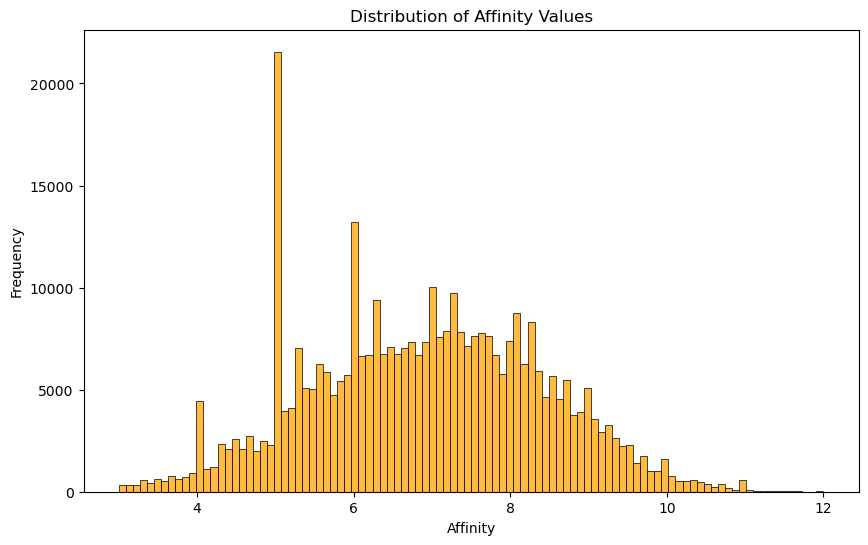

In [45]:
# plot affinity distribution 
plt.figure(figsize=(10, 6))
sns.histplot(ki_clean['affinity'], bins=100, color='orange')
plt.title('Distribution of Affinity Values')
plt.xlabel('Affinity')
plt.ylabel('Frequency')
plt.show()

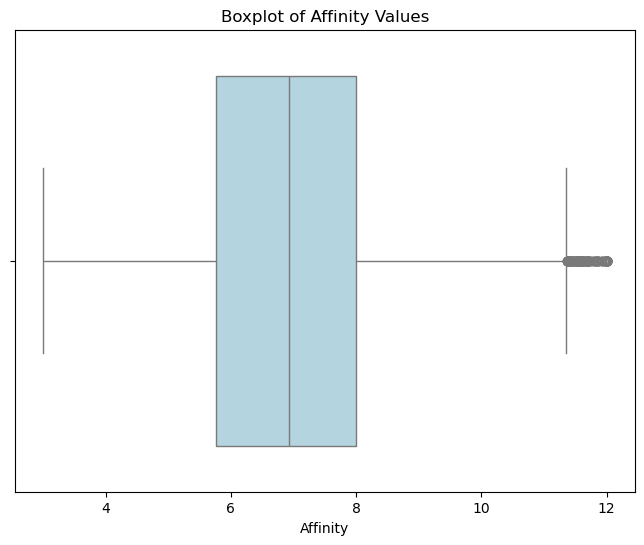

In [46]:
# boxplot ot check for outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x=ki_clean['affinity'], color='lightblue')
plt.title('Boxplot of Affinity Values')
plt.xlabel('Affinity')
plt.show()

In [48]:
# create 'activity' label based on affinity threshold (to convert project to classification task)
def classify_activity(pki):
    if pki >= 7:
        return 1 # means active
    elif pki <= 5:
        return 0 # means inactive/weak binder
    else:
        return np.nan # mark as intermediate or optional
    

# apply class labeling function
ki_clean['activity'] = ki_clean['affinity'].apply(classify_activity)
ki_clean.dropna(subset=['activity'], inplace=True)
# ki_clean['activity'] = ki_clean['activity'].astype(int)

In [50]:
ki_clean['activity'].value_counts()

activity
1.0    181140
0.0     49242
Name: count, dtype: int64

In [55]:
ki_clean['activity'].value_counts(normalize=True)

activity
1.0    0.786259
0.0    0.213741
Name: proportion, dtype: float64

In [52]:
ki_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230382 entries, 0 to 375447
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   smiles         230382 non-null  object 
 1   target_seq     230382 non-null  object 
 2   affinity       230382 non-null  float64
 3   smiles_length  230382 non-null  int64  
 4   activity       230382 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


In [53]:
ki_clean.shape

(230382, 5)

In [54]:
ki_clean.head()

,smiles,target_seq,affinity,smiles_length,activity
0,B[P@@](=O)(OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1c...,MERDGCAGGGSRGGEGGRAPREGPAGNGRDRGRSHAAEAPGDPQAA...,4.744727,87,0.0
2,B[P@](=O)(OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1cn...,MERDGCAGGGSRGGEGGRAPREGPAGNGRDRGRSHAAEAPGDPQAA...,4.251812,82,0.0
3,B[P@](=O)(OC[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1cn...,MERDGCAGGGSRGGEGGRAPREGPAGNGRDRGRSHAAEAPGDPQAA...,4.552842,86,0.0
5,Br.C(CN1CCc2ccccc2C1)Cc1nc2ccccc2s1,MALSYRVSELQSTIPEHILQSTFVHVISSNWSGLQTESIPEEMKQI...,7.744727,35,1.0
6,Br.C(CN1CCc2ccccc2C1)Cc1nc2ccccc2s1,MASLSQLSSHLNYTCGAENSTGASQARPHAYYALSYCALILAIVFG...,7.102373,35,1.0


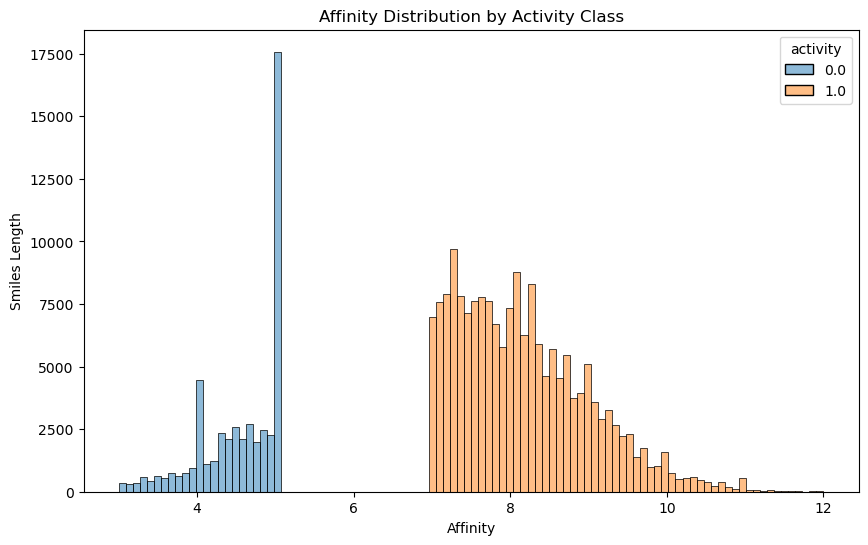

In [62]:
# plot smile affinity by activity
plt.figure(figsize=(10, 6))
sns.histplot(data=ki_clean, x='affinity', bins=100, hue='activity')
plt.title('Affinity Distribution by Activity Class')
plt.xlabel('Affinity')
plt.ylabel('Smiles Length')
plt.show()

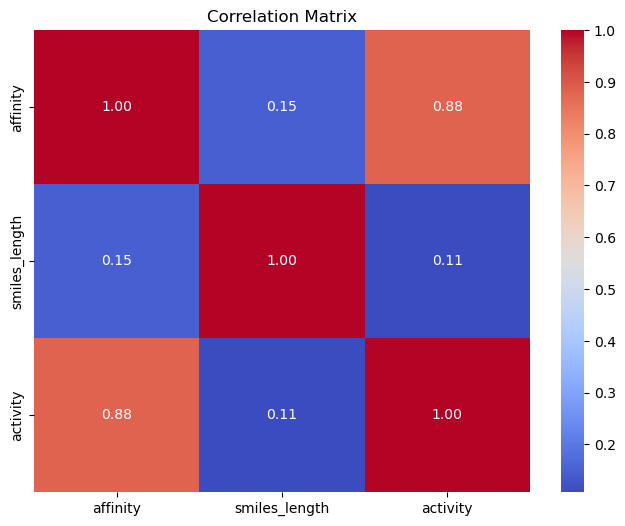

In [63]:
# plot correlation
num_cols = ['affinity', 'smiles_length', 'activity']
plt.figure(figsize=(8, 6))
sns.heatmap(ki_clean[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show() 